In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import time

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
batch_size = 128
learning_rate = 0.01
epochs = 10
input_size = 784
hidden_size = 512
num_classes = 10

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [5]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.6MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 497kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.58MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.96MB/s]


In [6]:
print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 60000
Test samples: 10000


In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.view(-1, input_size)
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x

In [8]:
def train_model(model, train_loader, test_loader, optimizer, criterion, epochs, optimizer_name):
    model.to(device)
    train_losses = []
    train_accuracies = []
    test_losses = []
    test_accuracies = []

    print(f"\nTraining with {optimizer_name} optimizer:")
    print("-" * 50)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = torch.max(output.data, 1)
            total_train += target.size(0)
            correct_train += (predicted == target).sum().item()

            if batch_idx % 100 == 0:
                print(f'Epoch {epoch+1}/{epochs}, Batch {batch_idx}, '
                      f'Loss: {loss.item():.6f}')

        avg_train_loss = train_loss / len(train_loader)
        train_accuracy = 100 * correct_train / total_train

        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0

        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                test_loss += criterion(output, target).item()
                _, predicted = torch.max(output.data, 1)
                total_test += target.size(0)
                correct_test += (predicted == target).sum().item()

        avg_test_loss = test_loss / len(test_loader)
        test_accuracy = 100 * correct_test / total_test

        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        test_losses.append(avg_test_loss)
        test_accuracies.append(test_accuracy)

        print(f'Epoch {epoch+1}/{epochs}: '
              f'Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
              f'Test Loss: {avg_test_loss:.4f}, Test Acc: {test_accuracy:.2f}%')

    return {
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'test_losses': test_losses,
        'test_accuracies': test_accuracies
    }

In [10]:
def create_model():
    return NeuralNetwork(input_size, hidden_size, num_classes)

criterion = nn.CrossEntropyLoss()
results = {}

In [11]:
print("=" * 60)
print("TRAINING WITH SGD OPTIMIZER")
print("=" * 60)
model_sgd = create_model()
optimizer_sgd = optim.SGD(model_sgd.parameters(), lr=learning_rate, momentum=0.9)
start_time = time.time()
results['SGD'] = train_model(model_sgd, train_loader, test_loader,
                            optimizer_sgd, criterion, epochs, 'SGD')
sgd_time = time.time() - start_time

TRAINING WITH SGD OPTIMIZER

Training with SGD optimizer:
--------------------------------------------------
Epoch 1/10, Batch 0, Loss: 2.310593
Epoch 1/10, Batch 100, Loss: 0.379207
Epoch 1/10, Batch 200, Loss: 0.201768
Epoch 1/10, Batch 300, Loss: 0.307458
Epoch 1/10, Batch 400, Loss: 0.159841
Epoch 1/10: Train Loss: 0.3947, Train Acc: 89.11%, Test Loss: 0.1695, Test Acc: 94.95%
Epoch 2/10, Batch 0, Loss: 0.235519
Epoch 2/10, Batch 100, Loss: 0.244086
Epoch 2/10, Batch 200, Loss: 0.207843
Epoch 2/10, Batch 300, Loss: 0.130548
Epoch 2/10, Batch 400, Loss: 0.082406
Epoch 2/10: Train Loss: 0.1385, Train Acc: 95.89%, Test Loss: 0.1060, Test Acc: 96.79%
Epoch 3/10, Batch 0, Loss: 0.071987
Epoch 3/10, Batch 100, Loss: 0.109546
Epoch 3/10, Batch 200, Loss: 0.132530
Epoch 3/10, Batch 300, Loss: 0.060268
Epoch 3/10, Batch 400, Loss: 0.066720
Epoch 3/10: Train Loss: 0.0918, Train Acc: 97.25%, Test Loss: 0.0838, Test Acc: 97.37%
Epoch 4/10, Batch 0, Loss: 0.102097
Epoch 4/10, Batch 100, Loss: 0

In [12]:
print("\n" + "=" * 60)
print("TRAINING WITH ADAM OPTIMIZER")
print("=" * 60)
model_adam = create_model()
optimizer_adam = optim.Adam(model_adam.parameters(), lr=learning_rate)
start_time = time.time()
results['Adam'] = train_model(model_adam, train_loader, test_loader,
                             optimizer_adam, criterion, epochs, 'Adam')
adam_time = time.time() - start_time


TRAINING WITH ADAM OPTIMIZER

Training with Adam optimizer:
--------------------------------------------------
Epoch 1/10, Batch 0, Loss: 2.297904
Epoch 1/10, Batch 100, Loss: 0.375045
Epoch 1/10, Batch 200, Loss: 0.210861
Epoch 1/10, Batch 300, Loss: 0.163874
Epoch 1/10, Batch 400, Loss: 0.259718
Epoch 1/10: Train Loss: 0.3385, Train Acc: 91.18%, Test Loss: 0.2077, Test Acc: 94.20%
Epoch 2/10, Batch 0, Loss: 0.239778
Epoch 2/10, Batch 100, Loss: 0.094275
Epoch 2/10, Batch 200, Loss: 0.414465
Epoch 2/10, Batch 300, Loss: 0.099226
Epoch 2/10, Batch 400, Loss: 0.074615
Epoch 2/10: Train Loss: 0.1727, Train Acc: 95.14%, Test Loss: 0.1618, Test Acc: 95.46%
Epoch 3/10, Batch 0, Loss: 0.125059
Epoch 3/10, Batch 100, Loss: 0.070453
Epoch 3/10, Batch 200, Loss: 0.079925
Epoch 3/10, Batch 300, Loss: 0.069485
Epoch 3/10, Batch 400, Loss: 0.171033
Epoch 3/10: Train Loss: 0.1527, Train Acc: 95.73%, Test Loss: 0.1978, Test Acc: 94.55%
Epoch 4/10, Batch 0, Loss: 0.104747
Epoch 4/10, Batch 100, Loss

In [13]:
print("\n" + "=" * 60)
print("TRAINING WITH RMSPROP OPTIMIZER")
print("=" * 60)
model_rmsprop = create_model()
optimizer_rmsprop = optim.RMSprop(model_rmsprop.parameters(), lr=learning_rate)
start_time = time.time()
results['RMSprop'] = train_model(model_rmsprop, train_loader, test_loader,
                                optimizer_rmsprop, criterion, epochs, 'RMSprop')
rmsprop_time = time.time() - start_time


TRAINING WITH RMSPROP OPTIMIZER

Training with RMSprop optimizer:
--------------------------------------------------
Epoch 1/10, Batch 0, Loss: 2.312969
Epoch 1/10, Batch 100, Loss: 0.736702
Epoch 1/10, Batch 200, Loss: 0.690461
Epoch 1/10, Batch 300, Loss: 0.263000
Epoch 1/10, Batch 400, Loss: 0.387455
Epoch 1/10: Train Loss: 10.9648, Train Acc: 83.61%, Test Loss: 0.4176, Test Acc: 88.08%
Epoch 2/10, Batch 0, Loss: 0.300415
Epoch 2/10, Batch 100, Loss: 0.325187
Epoch 2/10, Batch 200, Loss: 0.311062
Epoch 2/10, Batch 300, Loss: 0.174500
Epoch 2/10, Batch 400, Loss: 0.283593
Epoch 2/10: Train Loss: 0.2939, Train Acc: 92.14%, Test Loss: 0.2673, Test Acc: 92.34%
Epoch 3/10, Batch 0, Loss: 0.206254
Epoch 3/10, Batch 100, Loss: 0.239494
Epoch 3/10, Batch 200, Loss: 0.215859
Epoch 3/10, Batch 300, Loss: 0.224452
Epoch 3/10, Batch 400, Loss: 0.210743
Epoch 3/10: Train Loss: 0.2352, Train Acc: 93.71%, Test Loss: 0.2504, Test Acc: 93.27%
Epoch 4/10, Batch 0, Loss: 0.140352
Epoch 4/10, Batch 10

In [25]:
print("\n" + "=" * 60)
print("TRAINING TIMES COMPARISON")
print("=" * 60)
print(f"SGD: {sgd_time:.2f} seconds")
print(f"Adam: {adam_time:.2f} seconds")
print(f"RMSprop: {rmsprop_time:.2f} seconds")



TRAINING TIMES COMPARISON
SGD: 145.88 seconds
Adam: 135.74 seconds
RMSprop: 135.86 seconds


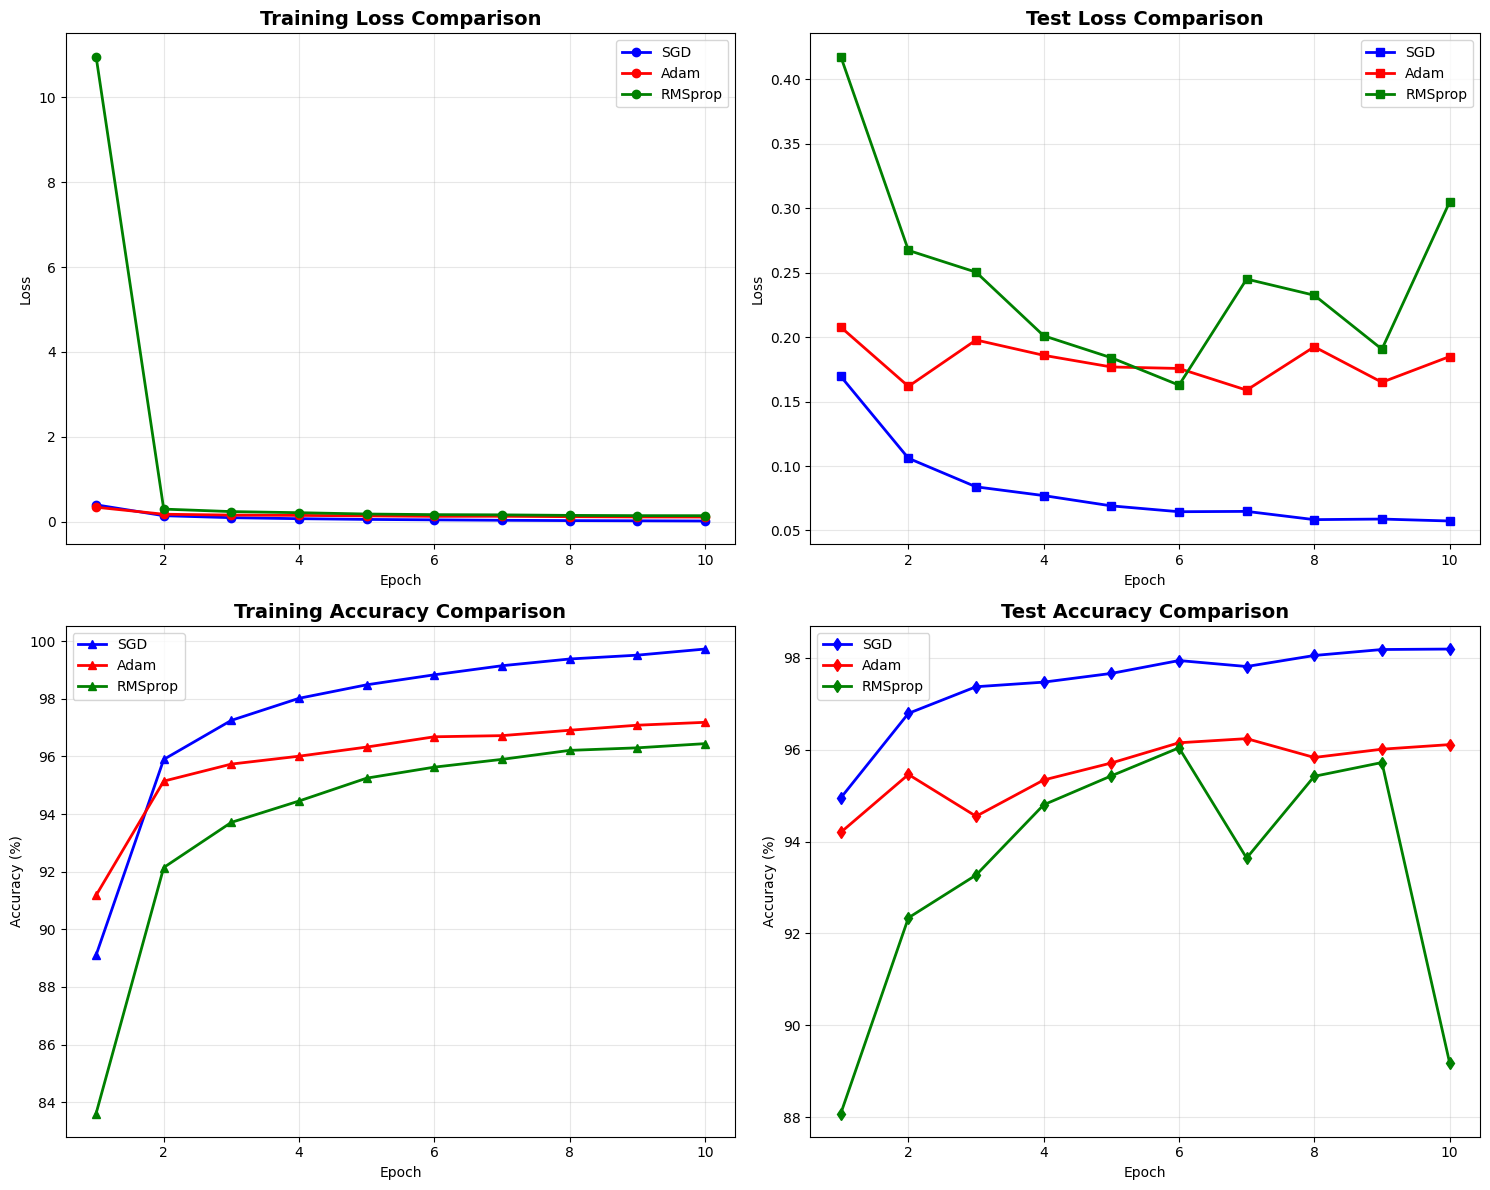

In [27]:
plt.style.use('default')
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

epochs_range = range(1, epochs + 1)
colors = {'SGD': 'blue', 'Adam': 'red', 'RMSprop': 'green'}
ax1.set_title('Training Loss Comparison', fontsize=14, fontweight='bold')
for optimizer_name, color in colors.items():
    ax1.plot(epochs_range, results[optimizer_name]['train_losses'],
             color=color, marker='o', label=optimizer_name, linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax2.set_title('Test Loss Comparison', fontsize=14, fontweight='bold')
for optimizer_name, color in colors.items():
    ax2.plot(epochs_range, results[optimizer_name]['test_losses'],
             color=color, marker='s', label=optimizer_name, linewidth=2)
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Loss')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax3.set_title('Training Accuracy Comparison', fontsize=14, fontweight='bold')
for optimizer_name, color in colors.items():
    ax3.plot(epochs_range, results[optimizer_name]['train_accuracies'],
             color=color, marker='^', label=optimizer_name, linewidth=2)
ax3.set_xlabel('Epoch')
ax3.set_ylabel('Accuracy (%)')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax4.set_title('Test Accuracy Comparison', fontsize=14, fontweight='bold')
for optimizer_name, color in colors.items():
    ax4.plot(epochs_range, results[optimizer_name]['test_accuracies'],
             color=color, marker='d', label=optimizer_name, linewidth=2)
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Accuracy (%)')
ax4.legend()
ax4.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [21]:
print("\n" + "=" * 80)
print("FINAL RESULTS COMPARISON")
print("=" * 80)
print(f"{'Optimizer':<12} {'Final Train Acc':<15} {'Final Test Acc':<15} {'Training Time':<15}")
print("-" * 80)
for optimizer_name in ['SGD', 'Adam', 'RMSprop']:
    train_acc = results[optimizer_name]['train_accuracies'][-1]
    test_acc = results[optimizer_name]['test_accuracies'][-1]
    if optimizer_name == 'SGD':
        time_taken = sgd_time
    elif optimizer_name == 'Adam':
        time_taken = adam_time
    else:
        time_taken = rmsprop_time

    print(f"{optimizer_name:<12} {train_acc:<15.2f} {test_acc:<15.2f} {time_taken:<15.2f}")


FINAL RESULTS COMPARISON
Optimizer    Final Train Acc Final Test Acc  Training Time  
--------------------------------------------------------------------------------
SGD          99.72           98.19           145.88         
Adam         97.18           96.11           135.74         
RMSprop      96.44           89.19           135.86         


<Figure size 1200x800 with 0 Axes>

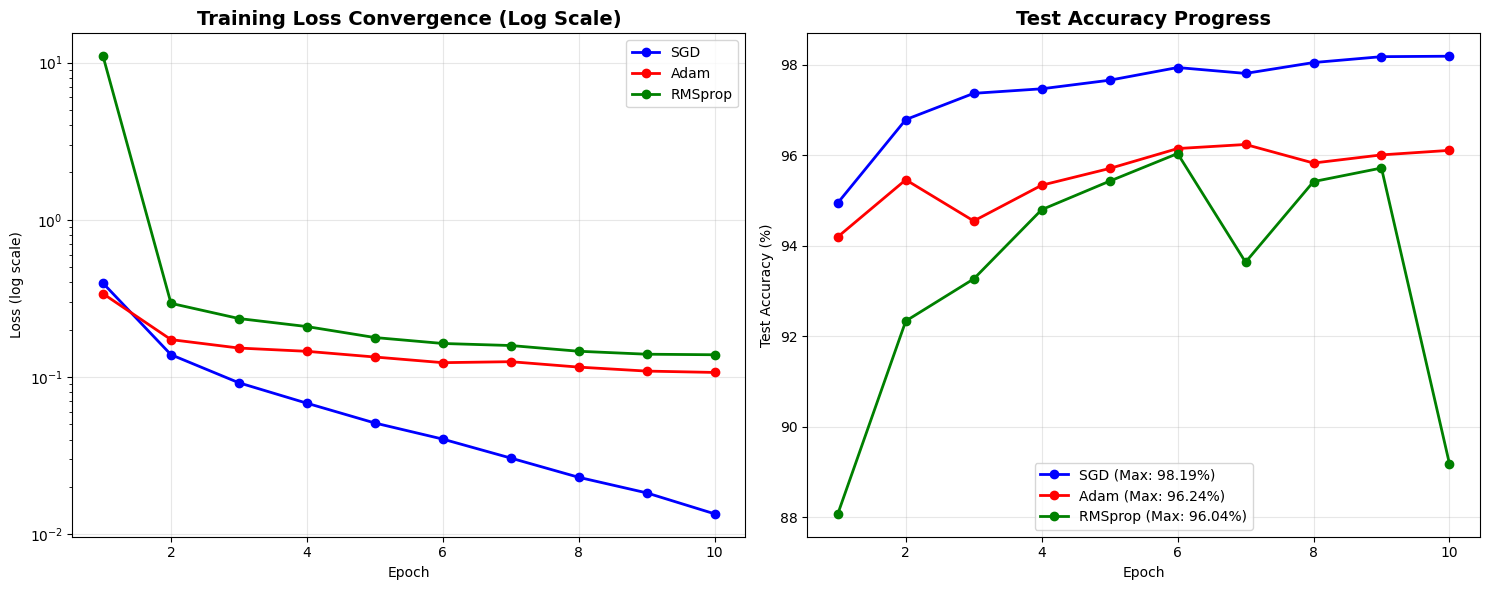

In [28]:
plt.figure(figsize=(12, 8))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.set_title('Training Loss Convergence (Log Scale)', fontsize=14, fontweight='bold')
for optimizer_name, color in colors.items():
    ax1.semilogy(epochs_range, results[optimizer_name]['train_losses'],
                 color=color, marker='o', label=optimizer_name, linewidth=2)
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss (log scale)')
ax1.legend()
ax1.grid(True, alpha=0.3)

ax2.set_title('Test Accuracy Progress', fontsize=14, fontweight='bold')
for optimizer_name, color in colors.items():
    accuracies = results[optimizer_name]['test_accuracies']
    ax2.plot(epochs_range, accuracies, color=color, marker='o',
             label=f"{optimizer_name} (Max: {max(accuracies):.2f}%)", linewidth=2)

ax2.set_xlabel('Epoch')
ax2.set_ylabel('Test Accuracy (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [29]:
best_optimizer = max(results.keys(),
                    key=lambda x: max(results[x]['test_accuracies']))
print(f"\nBest performing optimizer: {best_optimizer}")


Best performing optimizer: SGD
